In [444]:
import re
import ast
import json
from graphviz import Digraph

benchmark = 'd47b4702_9ef6'

cfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.colors'
task_style = {}
with open(cfile, 'r') as cfd:
    raw = cfd.read().split('\n')
    for ln in raw:
        if not ln: 
            continue
        task_name, actual = ln.split(',')
        if task_name not in task_style:
            task_style[task_name] = {}
        task_style[task_name]['actual'] = actual    

cfile = f'/local0/serverless-sim/results/{benchmark}.simcolors'
with open(cfile, 'r') as cfd:
    raw = cfd.read().split('\n')
    for ln in raw:
        if not ln: 
            continue
        task_name, simulator = ln.split(',')
        if task_name not in task_style:
            task_style[task_name] = {}
        task_style[task_name]['simulator'] = simulator 
        
        
for t in task_style:
    print(t, task_style[t])
    




execute_point_no_scratch-bdde6e20-8bf6-4e0a-860c-49f6eda04ad9 {'actual': '1', 'simulator': '1'}
join-d0780782-523e-4df5-84b1-6469ff285c29 {'actual': '1', 'simulator': '1'}
execute_point_no_scratch-f6e549ec-1a99-43be-95b8-2b2a21ff13c2 {'actual': '2', 'simulator': '2'}
execute_point_no_scratch-32316b05-4c0e-410f-a51e-614140510805 {'actual': '2', 'simulator': '2'}
execute_point_no_scratch-35db9730-1ae9-4341-a172-cec28f7ff5d7 {'actual': '2', 'simulator': '2'}
execute_point_no_scratch-acc0c637-1c17-48c3-a0e7-433420512f9a {'actual': '3', 'simulator': '5'}
execute_point_no_scratch-f1dd5be5-39c5-4c8a-8221-8fee53445899 {'actual': '3', 'simulator': '5'}
execute_point_no_scratch-4b20559d-9e81-4266-8742-e166911707a5 {'actual': '3', 'simulator': '5'}
execute_point_no_scratch-0874af24-2108-43ef-982f-8be8c95da253 {'actual': '3', 'simulator': '5'}
execute_point_no_scratch-6cdd9643-4a54-4868-bdac-3a7a2477e187 {'actual': '4', 'simulator': '4'}
execute_point_no_scratch-8d675ba9-b94e-43f9-bc4f-5c45c242a84

In [445]:
# color the graph
import graph_tool.all as gt
import copy
import matplotlib.colors as mcolors

css_colors = list(mcolors.CSS4_COLORS.keys())


gfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.g'



with open(gfile, 'r') as fd:
    raw = fd.read().split('\n')
    g = gt.Graph(directed=True)
    vid_to_vx = {}
    name_to_vid = {}
    
    g.vertex_properties['name'] = g.new_vertex_property("string")
    g.vertex_properties['color'] = g.new_vertex_property("string")
    g.vertex_properties['icolor'] = g.new_vertex_property("int")
    g.vertex_properties['simcolor'] = g.new_vertex_property("string")
    g.vertex_properties['isimcolor'] = g.new_vertex_property("string")
    for ln in raw:
        if ln.startswith('v'):
            _, vid, name = ln.split(',', 2)
            v = g.add_vertex()
            vid_to_vx[vid] = v
            name_to_vid[name] = vid
            
            g.vp.name[v] = name
            try:
                g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['actual'])]]
                g.vp.icolor[v] = int(task_style[name]['actual'])
                g.vp.simcolor[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['simulator'])]]
                g.vp.isimcolor[v] = int(task_style[name]['simulator'])
            #print(name, g.vp.icolor[v])
            except KeyError:
                g.vp.color[v] = 'yellow'
                g.vp.icolor[v] = 2
                
    for ln in raw:        
        if ln.startswith('e'):
            _, vsrc, vdst, _ = ln.split(',', 3)
            g.add_edge(vid_to_vx[vsrc], vid_to_vx[vdst])

In [446]:
dg = Digraph('G', filename=f'{benchmark}.gv', format='png')
for v in g.vertices():
    dg.attr('node', shape='ellipse', style='filled', color=g.vp.color[v])
    dg.node(f'{v}, color({g.vp.icolor[v]})')
    
for e in g.edges():
    dg.edge(f'{e.source()}, color({g.vp.icolor[e.source()]})', 
            f'{e.target()}, color({g.vp.icolor[e.target()]})')
    

dg.view(f'{benchmark}', quiet=False)

dg = Digraph('G', filename=f'{benchmark}.simulator.gv', format='png')
for v in g.vertices():
    dg.attr('node', shape='ellipse', style='filled', color=g.vp.simcolor[v])
    dg.node(f'{v}, color({g.vp.isimcolor[v]})')
    
for e in g.edges():
    dg.edge(f'{e.source()}, color({g.vp.isimcolor[e.source()]})', 
            f'{e.target()}, color({g.vp.isimcolor[e.target()]})')
    

dg.view(f'{benchmark}.simulator', quiet=False)

'd47b4702_9ef6.simulator.png'

In [447]:
gfile = f'/local0/serverless-sim/results/{benchmark}.syncwdeser.chain_color.log'


with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    for ts in data['tasks']:
        print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    

execute_point_no_scratch-acc0c637-1c17-48c3-a0e7-433420512f9a 0 0.02788100077886108 192.168.1.3
execute_point_no_scratch-bdde6e20-8bf6-4e0a-860c-49f6eda04ad9 0 0.028217170975394282 192.168.1.4
execute_point_no_scratch-6cdd9643-4a54-4868-bdac-3a7a2477e187 0 0.02827009989995483 192.168.1.3
execute_point_no_scratch-6862e51c-146d-417d-9da5-5f66823ceb56 0 0.028306101105399165 192.168.1.2
execute_point_no_scratch-d929207c-742a-4b2d-a5f6-657647589d59 0 0.028329227707572017 192.168.1.4
execute_point_no_scratch-e70c9e5a-0812-4319-9bc7-586f63284374 0 0.02839693858403686 192.168.1.2
execute_point_no_scratch-99a6ebd6-528f-4315-87ab-85ee939da6d9 0 0.029718731186575923 192.168.1.2
execute_point_no_scratch-b9b3883d-9b58-4b48-99f5-d5486734cf31 0 0.0298219664313269 192.168.1.2
execute_point_no_scratch-f1dd5be5-39c5-4c8a-8221-8fee53445899 0.02788100077886108 0.05623414370006779 192.168.1.3
execute_point_no_scratch-5b100386-a919-434c-9a66-a0754cfeda0f 0.028306101105399165 0.056839404886205584 192.168.1.2

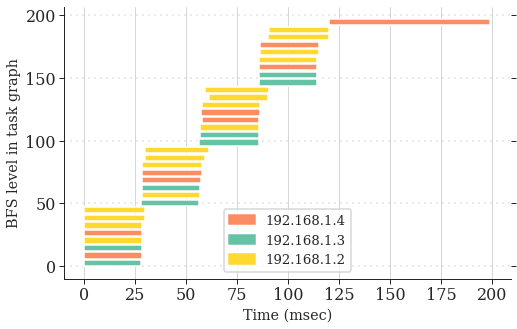

In [448]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import os
import json
import itertools
import matplotlib
import matplotlib.ticker as ticker

def format_xticks(x, pos=None):
    return str(int(x*1000))

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')


# Setting graph attribute
ax.grid(True)

workers_color = {'192.168.1.4': '#fc8d62',
               '192.168.1.3': '#66c2a5', 
                '192.168.1.2': '#ffd92f' }
with open(gfile, 'r') as fd:
    data = ast.literal_eval(fd.read())
    base = 0
    size = 5
    margin = 1
    for ts in data['tasks']:
        #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        #workers_load[ts['worker']].append((ts['start_ts'], ts['end_ts'] - ts['start_ts']))
        ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
                       facecolors =(workers_color[ts['worker']]))
        base += (size + margin)
ax.legend(['192.168.1.4', '192.168.1.3', '192.168.1.2'], loc=8)
ax.get_legend().legendHandles[0].set_color('#fc8d62')
ax.get_legend().legendHandles[1].set_color('#66c2a5')
ax.get_legend().legendHandles[2].set_color('#ffd92f')

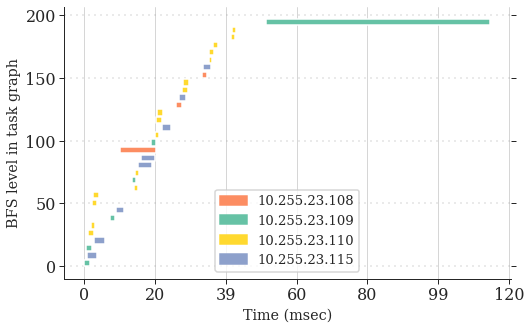

In [449]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'


tasks = []
with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    
    min_ts = sys.maxsize
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        for ss in startsstops:
            if ss['action'] == 'inputsize': continue
            if ss['start'] < min_ts:  min_ts = ss['start']
            if ss['stop'] < min_ts:  min_ts = ss['stop']
            
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        min_start = sys.maxsize
        max_end = 0
        
        for ss in startsstops:
            if ss['action'] == 'inputsize': continue
            if ss['start'] < min_start:  min_start = ss['start']
            if ss['stop'] > max_end:  max_end = ss['stop']
        
        tasks.append({'name': s, 'start_ts': min_start - min_ts, 'end_ts': max_end - min_ts, 
                      'worker': stats[s]['worker'].split(':')[1].replace('/', '')})
    

def format_xticks(x, pos=None):
    return str(int(x*1000))

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('Time (msec)')

sns.despine()
ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

ax.set_axisbelow(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))

#ax.set_yticks([5, 15, 27, 32, 40])
#ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_ylabel('BFS level in task graph')


# Setting graph attribute
ax.grid(True)

workers_color = {'10.255.23.108': '#fc8d62',
                 '10.255.23.109': '#66c2a5', 
                 '10.255.23.110': '#ffd92f',
                 '10.255.23.115': '#8da0cb'}



base = 0
size = 5
margin = 1
for ts in tasks:
    #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
    if ts['worker'] not in workers_load:
        workers_load[ts['worker']] = []
    ax.broken_barh([(ts['start_ts'], ts['end_ts'] - ts['start_ts'])], (base, size), 
                   facecolors =(workers_color[ts['worker']]))
    base += (size + margin)
    
ax.legend(list(workers_color.keys()), loc=8)
ax.get_legend().legendHandles[0].set_color('#fc8d62')
ax.get_legend().legendHandles[1].set_color('#66c2a5')
ax.get_legend().legendHandles[2].set_color('#ffd92f')
ax.get_legend().legendHandles[3].set_color('#8da0cb')

In [453]:
jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'


tasks = []
with open(jfile, 'r') as fd:
    stats = ast.literal_eval(fd.read())
    task_time = []
    for s in stats:
        task_style[s]['output_size'] = stats[s]['msg']['nbytes']
        startsstops = stats[s]['msg']['startstops']
        for ss in startsstops:
            if ss['action'] == 'compute': 
                #print(s, ss['stop'] - ss['start'], task_style[s]['output_size'])
                task_time.append(ss['stop'] - ss['start'])
import numpy as np
arr = np.array(task_time)

# measures of central tendency
mean = np.mean(arr)
median = np.median(arr)
  
# measures of dispersion
min = np.amin(arr)
max = np.amax(arr)
range = np.ptp(arr)
varience = np.var(arr)
sd = np.std(arr)
  
print("Descriptive analysis")
print("Array =", arr)
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", min)
print("Maximum =", max)
print("Range =", range)
print("Varience =", varience)
print("Standard Deviation =", sd)

Descriptive analysis
Array = [1.56736374e-03 3.01599503e-03 1.51443481e-03 3.11923027e-03
 1.60336494e-03 1.17826462e-03 1.31797791e-03 2.20775604e-03
 1.62649155e-03 1.69420242e-03 1.18017197e-03 1.19900703e-03
 9.90629196e-04 3.83996964e-03 3.85212898e-03 1.70135498e-03
 1.42931938e-03 1.31154060e-03 2.40087509e-03 1.79362297e-03
 1.93738937e-03 1.47509575e-03 1.94764137e-03 1.50322914e-03
 1.67298317e-03 1.54733658e-03 2.29215622e-03 1.02782249e-03
 1.28555298e-03 1.35970116e-03 1.13987923e-03 1.26361847e-03
 2.76565552e-05]
Measures of Central Tendency
Mean = 0.0017279928380792792
Median = 0.0015473365783691406
Measures of Dispersion
Minimum = 2.765655517578125e-05
Maximum = 0.0038521289825439453
Range = 0.003824472427368164
Varience = 6.074131343333292e-07
Standard Deviation = 0.0007793671370627126
